Imports

In [388]:
import csv
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.sparse import hstack
import matplotlib.pyplot as plt

Load the transaction data from the csv file into a numpy array.

In [389]:
file_path = 'TransactionDS.csv'
with open(file_path, 'r') as file:
    data_iterator = csv.reader(file, delimiter=';')
    data_list = list(data_iterator)
data = np.asarray(data_list)

# TODO datatype


Remove first row (descriptions), remove first column (ids)
and split labels from input data.

In [390]:
data = data[1:,:]
data = data[:,1:]
x, y = data[:,:-1], data[:,-1]



Preprocessing of amount, interpreted continuous: Converted to float and normalized in range [-1, 1]

In [391]:
repl_vec = np.vectorize(lambda s: s.replace(',', '.'))
dot_amount = repl_vec(x[:,8])
float_amount = np.asfarray(dot_amount, float)
float_amount /= np.max(np.abs(float_amount))
float_amount = np.reshape(float_amount, (float_amount.size, 1))
print(float_amount.shape)

(209, 1)


Preprocessing of text data, CountVectorizer and TfidTransformer

In [392]:
count_vec_bt = CountVectorizer()
count_vec_vz = CountVectorizer()
bt_vec = count_vec_bt.fit_transform(x[:,3])
vz_vec = count_vec_vz.fit_transform(x[:,4])

tf_trans_bt = TfidfTransformer(use_idf=False).fit(bt_vec)
bt_freq = tf_trans_bt.transform(bt_vec)
tf_trans_vz = TfidfTransformer(use_idf=False).fit(vz_vec)
vz_freq = tf_trans_vz.transform(vz_vec)

print(bt_freq.shape)
print(vz_freq.shape)

(209, 21)
(209, 339)


One hot encoding for all other data


In [393]:
remaining_data = np.delete(x, 8, 1)
remaining_data = np.delete(remaining_data, 3, 1)
remaining_data = np.delete(remaining_data, 4, 1)

enc = OneHotEncoder(drop='first', handle_unknown='error')
enc.fit(remaining_data)
data_cat = enc.transform(remaining_data)
print(data_cat.shape)

(209, 387)


Joint all together

In [394]:
final_x = hstack((float_amount, bt_freq, vz_freq, data_cat))
final_x = final_x.toarray()
print(final_x.shape)

(209, 748)


Encode the class labels

In [395]:
le = LabelEncoder()
le.fit(y)
y_num = le.transform(y)

Define and evaluate the model using cross validation with five folds
Get the confusion matrix of all runs averaged


[]

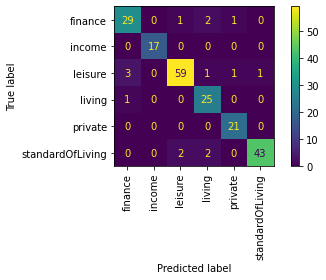

In [396]:
conf_matrix_list = []
kf = KFold(n_splits=5)
for train_i, test_i in kf.split(y_num):
    x_train, x_test = final_x[train_i], final_x[test_i]
    y_train, y_test = y_num[train_i], y_num[test_i]
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)
    conf = confusion_matrix(y_test, gnb.predict(x_test))
    conf_matrix_list.append(conf)
confusion_sum = np.sum(conf_matrix_list, axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_sum, display_labels=le.classes_)
fig, ax = plt.subplots(1, 1)
disp.plot(xticks_rotation='vertical', ax=ax)
plt.tight_layout()
plt.savefig("ConfusionMatrix", dpi=400)
plt.plot()
#print(confusion_sum)
#print(le.classes_)